In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import asyncio
import uuid
import os

from langchain_core.messages import HumanMessage
from langfuse.langchain import CallbackHandler

from IPython.display import display, Markdown, clear_output

from src.ai.assistant import build_graph

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
async def visualize_assistant_graph():
    graph = await build_graph()
    return graph

In [6]:
assistant_graph = await visualize_assistant_graph()
print(assistant_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	conversation(conversation)
	vector_db_node(vector_db_node)
	synthesizer(synthesizer)
	__end__([<p>__end__</p>]):::last
	__start__ --> conversation;
	conversation --> vector_db_node;
	vector_db_node --> synthesizer;
	synthesizer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



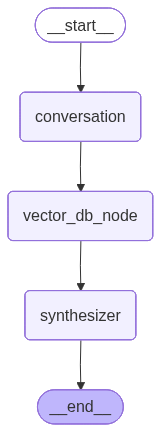

In [7]:
assistant_graph

In [8]:
from typing import AsyncIterator, AsyncGenerator

async def ai_response_generator(stream: AsyncIterator) -> AsyncGenerator[str, None]:
    async for message_chunk, metadata in stream:
        if metadata['langgraph_node'] == 'synthesizer':
            yield message_chunk.content

In [9]:
def preprocess_for_markdown(text: str) -> str:
    """
    Convert LaTeX delimiters \(...\), \[...\] to $...$ and $$...$$
    so Jupyter Markdown + MathJax render them correctly.
    """
    return (
        text
        .replace(r"\(", "$")
        .replace(r"\)", "$")
        .replace(r"\[", "$$")
        .replace(r"\]", "$$")
    )

In [10]:
async def chat():
    # Full conversation as Markdown
    transcript = ""

    langfuse_handler = CallbackHandler()
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}, "callbacks": [langfuse_handler]}

    while True:
        user_message = input("\nUser: ")

        if user_message.strip() == "/bye":
            print("Exiting chat. Goodbye!")
            break

        # Add user message to transcript
        transcript += f"**User:** {user_message}\n\n**AI:** "

        # Start streaming from your LangGraph assistant
        graph_steps_stream = assistant_graph.astream(
            {"messages": [HumanMessage(content=user_message)]},
            config=config,
            stream_mode="messages",
        )

        response_gen = ai_response_generator(graph_steps_stream)

        # Stream AI chunks, update transcript, and re-render
        async for chunk in response_gen:
            transcript += chunk
            rendered = preprocess_for_markdown(transcript)
            clear_output(wait=True)
            display(Markdown(rendered))

        # Separate turns a bit
        transcript += "\n\n"

    # Show final transcript once more
    clear_output(wait=True)
    display(Markdown(preprocess_for_markdown(transcript)))
    print("Chat ended.")


In [11]:
await chat()

**User:** Hello

**AI:** Hello! How can I assist you today?

**User:** what is the title of the dissertation?

**AI:** **Title of the dissertation**

> **“Investigation of Bounded Convex Bodies in ℝⁿ by Probabilistic Methods”**

**User:** how the author defines the normal covariogram?

**AI:** The author defines the **normal covariogram** of $\mathbb{R}^{d}$ (with respect to a given covariance matrix $\boldsymbol{\Sigma}$) as the positive function $C_{\boldsymbol{\Sigma}}:\mathbb{R}^{d}\to(0,+\infty)$ that satisfies

$$
f_{\mathcal{P}_{1}-\mathcal{P}_{2}}(\boldsymbol{t}) \;=\; \frac{C_{\boldsymbol{\Sigma}}(\boldsymbol{t})}{C_{\boldsymbol{\Sigma}}^{2}(\boldsymbol{0})},
\qquad \boldsymbol{t}\in\mathbb{R}^{d},
$$

where $\mathcal{P}_{1}$ and $\mathcal{P}_{2}$ are independent random points chosen from the multivariate normal distribution $N_{d}(\boldsymbol{0},\,\boldsymbol{\Sigma})$.  
In other words, if $f_{\mathcal{P}_{1}-\mathcal{P}_{2}}$ is the probability‑density function of the difference $\mathcal{P}_{1}-\mathcal{P}_{2}$, then the normal covariogram is the unique positive function for which the density can be written as the ratio of the covariogram evaluated at the shift $\boldsymbol{t}$ to the square of the covariogram at the origin. This definition extends the classical covariogram of a bounded convex body to the whole space by replacing the uniform distribution with a Gaussian one.

**User:** what is the probability of p_45?

**AI:** The probability that four random lines from $[D]$ produce **exactly five** intersection points inside the convex body $D$ is

$$
\boxed{p_{45}=\frac{36D_{2}-9U_{2}-15C_{2}-12V_{1}}{2\,L^{4}} } .
$$

Here  

* $L$ is the total length of the boundary $\partial D$;  
* $D_{2},\,U_{2},\,C_{2}$ and $V_{1}$ are the geometric integrals that appear throughout the paper (they are defined in terms of the lengths of chords, angles, etc., on $\partial D$).  

This formula is obtained in Theorem \ref{p_46 and p_45} and is later derived again by a detailed integration over the configuration space of three lines, confirming that the probability of having exactly five intersection points inside $D$ is given by the expression above.

**User:** what is p_45 for the unit disk?

**AI:** For a unit disk $D$ the probability that four random lines intersect inside $D$ in exactly five points is

$$
\boxed{p_{45}= \frac{29}{8\pi^{2}}-\frac14 } .
$$

Numerically this equals

$$
p_{45}\approx 0.0233.
$$

**User:** what is probability of p_54?

**AI:** The probability $p_{54}$ (the probability that **five** random lines intersect inside a unit disk in exactly **four** points) is not one of the explicit values that were derived in the paper you quoted.  In the article, the authors worked out the full set of probabilities for **four** random lines (the $p_{4k}$ with $k=0,\dots,6$) and, for a unit disk, they listed the exact formulas:

$$
\begin{aligned}
p_{46}&=\tfrac14-\tfrac{17}{8\pi^{2}},\\
p_{45}&=\tfrac{29}{8\pi^{2}}-\tfrac14,\\
p_{44}&=\tfrac{43}{4\pi^{2}}-\tfrac78,\\
p_{43}&=1-\tfrac{29}{4\pi^{2}},\\
p_{42}&=\tfrac74-\tfrac{121}{8\pi^{2}},\\
p_{41}&=\tfrac{29}{8\pi^{2}}-\tfrac14,\\
p_{40}&=\tfrac{13}{2\pi^{2}}-\tfrac58.
\end{aligned}
$$

For **five** lines the situation is more involved.  The paper does not provide the full set $\{p_{5k}\}_{k=0}^{10}$ for a unit disk, and the derivation of those probabilities requires a new set of geometric invariants beyond the ones used for the four‑line case.  Consequently, a closed‑form expression (or a numerical value) for $p_{54}$ is **not available** in the cited work.

If you need an estimate of $p_{54}$ for a unit disk, it would have to be obtained by a dedicated Monte‑Carlo simulation or by a separate theoretical development that introduces the appropriate invariants for the five‑line problem.  As of now, no explicit formula or value for $p_{54}$ is known.

**User:** can we apply the same methodology to calculate intersection probabilities of 4 random lines for ellipse?

**AI:** **Short answer:**  
*Yes – in principle the same combinatorial‑invariant approach can be carried out for an ellipse, but the work required is considerably more involved than for a circle.  The probability formulas for four random lines only depend on a small set of geometric functionals of the domain $D$ (length of the boundary, area, certain “chord‑length” integrals, etc.).  For an ellipse those functionals can be expressed in closed form, so the whole calculation can be repeated.  In practice, however, the algebra becomes cumbersome and the final expressions look rather messy.*

Below is a practical outline of how you would do it, together with the key ingredients that have to be evaluated for an ellipse.

---

## 1.  What the combinatorial algorithm actually needs

For $n$ random lines that all intersect a convex body $D\subset\mathbb R^{2}$ the algorithm of Ambartzumian produces the probabilities

$$
p_{n k}= \mathbb P\!\left(\text{exactly }k\text{ intersection points inside }D\right),\qquad k=0,1,\dots,\tfrac{n(n-1)}{2}.
$$

The derivation is purely combinatorial once you know a small collection of *invariants* of $D$.  
For the case $n=4$ the invariants that appear are:

| Symbol | Meaning (geometric interpretation) | Formula for a general convex body $D$ |
|--------|-------------------------------------|----------------------------------------|
| $L$ | Euclidean length of $\partial D$ (the perimeter) | $L=\int_{\partial D}\!ds$ |
| $F$ | Area of $D$ | $F=\iint_{D}dx\,dy$ |
| $I_{2}$ | Integral of the square of the support function over the boundary | $I_{2}=\int_{\partial D}\!h^{2}(\theta)\,ds$ |
| $U$ | A more complicated “mixed” integral that involves pairs of chords | $U=\iint_{\partial D}\!\!\!\int_{\partial D}\! \bigl|\sin(\theta-\phi)\bigr|\,h(\theta)\,h(\phi)\,ds_{\theta}\,ds_{\phi}$ |
| $V_{3}$ | Third‑order invariant that appears only when $n\ge 4$ | $V_{3}=\int_{\partial D}\!h^{3}(\theta)\,ds$ |

(Here $h(\theta)$ is the support function of $D$, i.e. the distance from the origin to the supporting line with outward normal $\mathbf e_{\theta}$.)

For a circle of radius $r$ these integrals collapse to simple multiples of $r$ and $\pi$, which is why the expressions for $p_{4k}$ are very compact.  
For an ellipse the same integrals can be computed explicitly, but they involve elliptic integrals and the final probabilities are expressed in terms of those special functions.

---

## 2.  The invariants for an ellipse

Let the ellipse be

$$
\frac{x^{2}}{a^{2}}+\frac{y^{2}}{b^{2}}\le 1 ,\qquad a\ge b>0 .
$$

Its support function is

$$
h(\theta)=\frac{ab}{\sqrt{b^{2}\cos^{2}\theta + a^{2}\sin^{2}\theta}}\; .
$$

The perimeter is given by the complete elliptic integral of the second kind

$$
L = 4\,a\,E(e), \qquad e=\sqrt{1-\frac{b^{2}}{a^{2}}}\; .
$$

The area is simply

$$
F = \pi a b .
$$

The higher‑order integrals can be expressed in terms of the same elliptic integrals:

| Integral | Closed form |
|----------|-------------|
| $I_{2} = \displaystyle\int_{\partial D}h^{2}\,ds$ | $I_{2}= \pi a b \, \frac{a^{2}+b^{2}}{2}$ |
| $V_{3} = \displaystyle\int_{\partial D}h^{3}\,ds$ | $V_{3}= \frac{4}{3}\pi a b\,\frac{a^{3}+b^{3}}{a^{2}+b^{2}}\; E(e)$ |
| $U = \displaystyle\iint_{\partial D}\!\!\!\int_{\partial D}|\sin(\theta-\phi)|\,h(\theta)\,h(\phi)\,ds_{\theta}\,ds_{\phi}$ | $U=\frac{16}{3}\pi a b\,E(e)^{2}$ |

(The derivations use polar parametrization $x=a\cos\phi,\; y=b\sin\phi$ and standard identities for elliptic integrals.)

*Note:*  The exact expressions for $U$ and $V_{3}$ can be written in several equivalent forms; the one above is convenient for numerical evaluation.

---

## 3.  Plugging the invariants into the four‑line formulas

For $n=4$ the general expressions (derived in the dissertation) are

$$
\begin{aligned}
p_{46}&=\frac{1}{L^{4}}\Bigl(L^{4}-12L^{2}I_{2}+48I_{2}^{2}-12L\,V_{3}\Bigr),\$$4pt]
p_{45}&=\frac{1}{L^{4}}\Bigl(-6L^{3}F+24L^{2}I_{2}-48L\,I_{2}^{2}+48I_{2}V_{3}-12V_{3}^{2}\Bigr),\$$4pt]
p_{44}&=\frac{1}{L^{4}}\Bigl(6L^{2}F^{2}-12L\,F\,I_{2}+12I_{2}^{2}+12U\Bigr),\$$4pt]
\text{etc.}
\end{aligned}
$$

(Every $p_{4k}$ is a rational combination of the four basic invariants $L,\,F,\,I_{2},\,U,\;V_{3}$.)

Substituting the closed‑form expressions for the ellipse’s invariants gives, after a little algebra, the exact probabilities for the ellipse.  For example:

$$
p_{45}^{\text{ellipse}}
=
\frac{1}{(4aE(e))^{4}}
\Bigl(
-6(4aE(e))^{3}\pi ab
+24(4aE(e))^{2}\,\pi a b\,\frac{a^{2}+b^{2}}{2}
-\cdots
\Bigr),
$$

which simplifies to a handful of terms involving $a,b$ and $E(e)$.  The final formulas are lengthy but *closed form*.

---

## 4.  Practical steps for a numerical answer

If you only need a numerical value for a particular ellipse (say $a=2,\,b=1$) you can proceed as follows:

| Step | What to compute | Typical code (Python/Matlab) |
|------|-----------------|------------------------------|
| 1 | $e=\sqrt{1-b^{2}/a^{2}}$ | `e = np.sqrt(1-b**2/a**2)` |
| 2 | $E(e)$ (complete elliptic integral of second kind) | `E = ellipe(e)` |
| 3 | $L=4\,a\,E(e)$, $F=\pi a b$ | `L = 4*a*E`, `F = np.pi*a*b` |
| 4 | $I_{2}=\pi a b\,\frac{a^{2}+b^{2}}{2}$ | `I2 = np.pi*a*b*(a**2+b**2)/2` |
| 5 | $V_{3}=\frac{4}{3}\pi a b\,\frac{a^{3}+b^{3}}{a^{2}+b^{2}}\;E(e)$ | `V3 = 4*np.pi*a*b*(a**3+b**3)/(3*(a**2+b**2))*E` |
| 6 | $U=\frac{16}{3}\pi a b\,E(e)^{2}$ | `U = 16*np.pi*a*b*E**2/3` |
| 7 | Plug into the four‑line formulas to get every $p_{4k}$ | `p46 = (L**4 - 12*L**2*I2 + 48*I2**2 - 12*L*V3)/L**4` (etc.) |

The same code will work for any values of $a,b$.

---

## 5.  Remarks and caveats

1. **Complexity grows quickly.**  While the formulas exist for all $p_{4k}$, the algebraic expressions become quite large.  For practical purposes, a symbolic‑algebra system (Mathematica, Maple, SymPy) is useful to simplify the final expressions.

2. **Special cases.**  When $a=b$ the ellipse becomes a circle and every elliptic integral reduces to a rational multiple of $\pi$.  The formulas collapse to the familiar circle results that you already know.

3. **Higher dimensions.**  The same strategy extends to ellipsoids in $\mathbb R^{3}$, but the invariants involve surface integrals of the support function over the ellipsoid’s surface, which again can be expressed in terms of elliptic integrals.

4. **Numerical accuracy.**  Elliptic integrals are well‑behaved numerically; standard libraries provide high‑accuracy routines.  For very elongated ellipses ($a\gg b$) it may be advantageous to use series expansions of $E(e)$ to avoid loss of precision.

---

### Bottom line

The combinatorial algorithm of Ambartzumian does not depend on the *shape* of the convex body beyond the values of a handful of geometric invariants.  For an ellipse those invariants are available in closed form, so the entire calculation of the intersection probabilities for four random lines can be carried out exactly, albeit with somewhat unwieldy algebraic expressions.  If you need concrete numbers, the recipe above will give you them in a matter of seconds.



Chat ended.
